In [1]:
import os
os.chdir('../../src')

import datetime
import torch
import torch.nn as nn

from transformer.models import TransformerDecoder
from data import GPCurvesReader
from utils import plot_functions

In [2]:
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
MAX_CONTEXT_POINTS = 10
torch.manual_seed(0)

# Train dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/vol/bitbucket/ls1221/fyp/fypenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Total parameters: 1,580,289
Iteration: 0, train loss: 1.7615852355957031
2025-05-06 14:08:33, Iteration: 0, Test Loss: 5.549404144287109


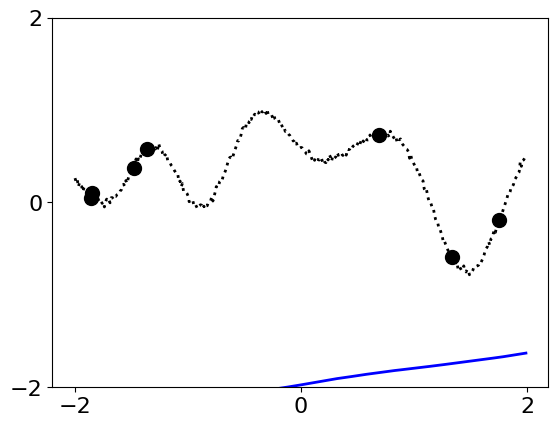

Iteration: 1000, train loss: 0.9338041543960571
Iteration: 2000, train loss: 0.712522029876709
Iteration: 3000, train loss: 0.6933548450469971
Iteration: 4000, train loss: 0.6240985989570618
Iteration: 5000, train loss: 0.635117769241333
Iteration: 6000, train loss: 0.6737731695175171
Iteration: 7000, train loss: 0.6623054146766663
Iteration: 8000, train loss: 0.6817492842674255
Iteration: 9000, train loss: 0.562188982963562
Iteration: 10000, train loss: 0.6147271990776062
Iteration: 11000, train loss: 0.7069398760795593
Iteration: 12000, train loss: 0.601880669593811
Iteration: 13000, train loss: 0.5789585113525391
Iteration: 14000, train loss: 0.5261015892028809
Iteration: 15000, train loss: 0.39892423152923584
Iteration: 16000, train loss: 0.4369618892669678
Iteration: 17000, train loss: 0.49946272373199463
Iteration: 18000, train loss: 0.6336531639099121
Iteration: 19000, train loss: 0.6093834042549133
Iteration: 20000, train loss: 0.531689465045929
2025-05-06 14:25:08, Iteration: 

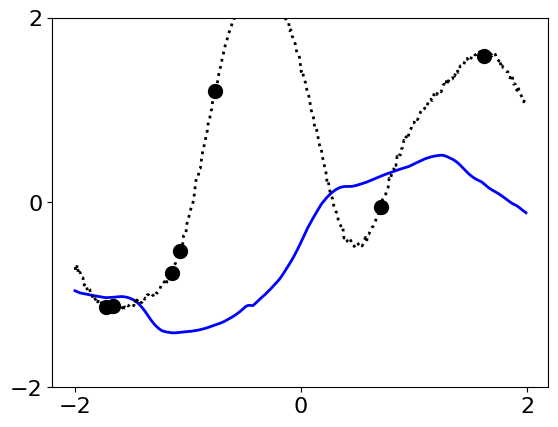

Iteration: 21000, train loss: 0.49971094727516174
Iteration: 22000, train loss: 0.4988401234149933
Iteration: 23000, train loss: 0.5269443392753601
Iteration: 24000, train loss: 0.4332340359687805
Iteration: 25000, train loss: 0.4074788987636566
Iteration: 26000, train loss: 0.5791571140289307
Iteration: 27000, train loss: 0.4183832108974457
Iteration: 28000, train loss: 0.4381318986415863
Iteration: 29000, train loss: 0.5374624133110046
Iteration: 30000, train loss: 0.45371171832084656
Iteration: 31000, train loss: 0.46607705950737
Iteration: 32000, train loss: 0.4512435793876648
Iteration: 33000, train loss: 0.4586963951587677
Iteration: 34000, train loss: 0.3893386423587799
Iteration: 35000, train loss: 0.6165868043899536
Iteration: 36000, train loss: 0.34371039271354675
Iteration: 37000, train loss: 0.5101739764213562
Iteration: 38000, train loss: 0.5236763954162598
Iteration: 39000, train loss: 0.48353374004364014
Iteration: 40000, train loss: 0.45110461115837097
2025-05-06 14:41:

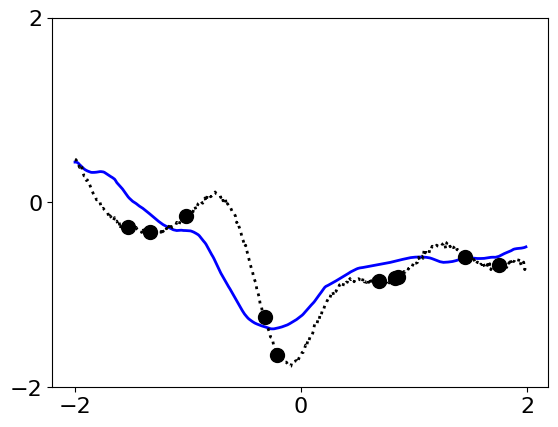

Iteration: 41000, train loss: 0.37941238284111023
Iteration: 42000, train loss: 0.42636382579803467
Iteration: 43000, train loss: 0.4381754994392395
Iteration: 44000, train loss: 0.42193883657455444
Iteration: 45000, train loss: 0.3813469111919403
Iteration: 46000, train loss: 0.37380728125572205
Iteration: 47000, train loss: 0.3092673420906067
Iteration: 48000, train loss: 0.36031368374824524
Iteration: 49000, train loss: 0.476218044757843
Iteration: 50000, train loss: 0.43053051829338074
Iteration: 51000, train loss: 0.35871946811676025
Iteration: 52000, train loss: 0.3743467926979065
Iteration: 53000, train loss: 0.541771411895752
Iteration: 54000, train loss: 0.46793290972709656
Iteration: 55000, train loss: 0.415088415145874
Iteration: 56000, train loss: 0.36357441544532776
Iteration: 57000, train loss: 0.2576293349266052
Iteration: 58000, train loss: 0.40534329414367676
Iteration: 59000, train loss: 0.40572842955589294
Iteration: 60000, train loss: 0.32103702425956726
2025-05-06 

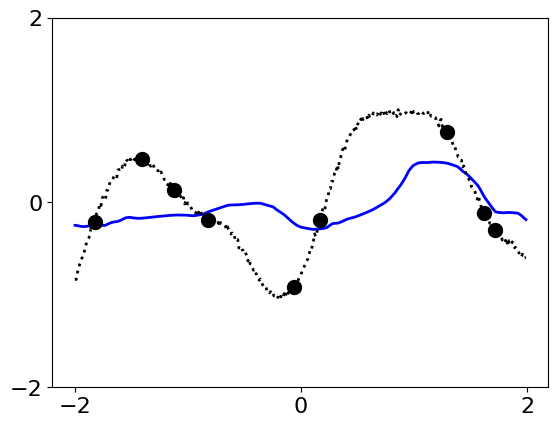

Iteration: 61000, train loss: 0.23648372292518616
Iteration: 62000, train loss: 0.46757325530052185
Iteration: 63000, train loss: 0.44590216875076294
Iteration: 64000, train loss: 0.4756980538368225
Iteration: 65000, train loss: 0.44217270612716675
Iteration: 66000, train loss: 0.44797182083129883
Iteration: 67000, train loss: 0.3806481659412384
Iteration: 68000, train loss: 0.37063249945640564
Iteration: 69000, train loss: 0.4020306468009949
Iteration: 70000, train loss: 0.32885873317718506
Iteration: 71000, train loss: 0.3998832106590271
Iteration: 72000, train loss: 0.4917053282260895
Iteration: 73000, train loss: 0.4657883644104004
Iteration: 74000, train loss: 0.3907760679721832
Iteration: 75000, train loss: 0.4145992398262024
Iteration: 76000, train loss: 0.3849080801010132
Iteration: 77000, train loss: 0.46918749809265137
Iteration: 78000, train loss: 0.39597612619400024
Iteration: 79000, train loss: 0.3939222991466522
Iteration: 80000, train loss: 0.30775076150894165
2025-05-06

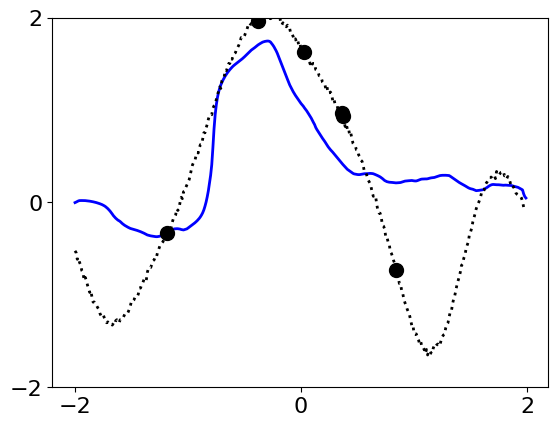

Iteration: 81000, train loss: 0.3798845410346985
Iteration: 82000, train loss: 0.2923033535480499
Iteration: 83000, train loss: 0.418555349111557
Iteration: 84000, train loss: 0.3732115626335144
Iteration: 85000, train loss: 0.2773437798023224
Iteration: 86000, train loss: 0.3801847994327545
Iteration: 87000, train loss: 0.37799182534217834
Iteration: 88000, train loss: 0.3396308720111847
Iteration: 89000, train loss: 0.4041393995285034
Iteration: 90000, train loss: 0.32578372955322266
Iteration: 91000, train loss: 0.30336764454841614
Iteration: 92000, train loss: 0.5788500905036926
Iteration: 93000, train loss: 0.4369906783103943
Iteration: 94000, train loss: 0.33063948154449463
Iteration: 95000, train loss: 0.5053771138191223
Iteration: 96000, train loss: 0.38386639952659607
Iteration: 97000, train loss: 0.42130246758461
Iteration: 98000, train loss: 0.49578559398651123
Iteration: 99000, train loss: 0.3719721734523773
Iteration: 100000, train loss: 0.3435260057449341
2025-05-06 15:30

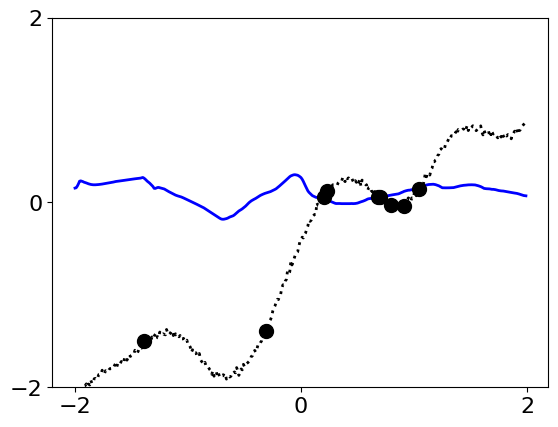

Iteration: 101000, train loss: 0.4733852446079254
Iteration: 102000, train loss: 0.4172626733779907
Iteration: 103000, train loss: 0.24186253547668457
Iteration: 104000, train loss: 0.3569503724575043
Iteration: 105000, train loss: 0.39796844124794006
Iteration: 106000, train loss: 0.38383904099464417
Iteration: 107000, train loss: 0.31985896825790405
Iteration: 108000, train loss: 0.3602209985256195
Iteration: 109000, train loss: 0.42880263924598694
Iteration: 110000, train loss: 0.40400823950767517
Iteration: 111000, train loss: 0.4406138062477112
Iteration: 112000, train loss: 0.4845944046974182
Iteration: 113000, train loss: 0.4066862463951111
Iteration: 114000, train loss: 0.4472317099571228
Iteration: 115000, train loss: 0.37402939796447754
Iteration: 116000, train loss: 0.38737595081329346
Iteration: 117000, train loss: 0.4669329524040222
Iteration: 118000, train loss: 0.3984982371330261
Iteration: 119000, train loss: 0.3645671308040619
Iteration: 120000, train loss: 0.365319341

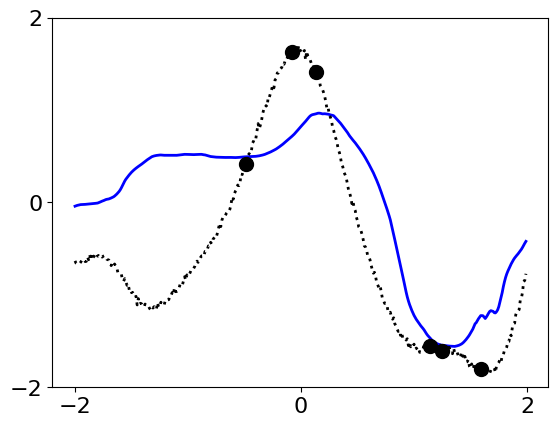

Iteration: 121000, train loss: 0.28418657183647156
Iteration: 122000, train loss: 0.314378947019577
Iteration: 123000, train loss: 0.4546126127243042
Iteration: 124000, train loss: 0.39781954884529114
Iteration: 125000, train loss: 0.33277711272239685
Iteration: 126000, train loss: 0.33084365725517273
Iteration: 127000, train loss: 0.4838867783546448
Iteration: 128000, train loss: 0.36491596698760986
Iteration: 129000, train loss: 0.34344035387039185
Iteration: 130000, train loss: 0.3669031262397766
Iteration: 131000, train loss: 0.5171632766723633
Iteration: 132000, train loss: 0.3954184651374817
Iteration: 133000, train loss: 0.33106565475463867
Iteration: 134000, train loss: 0.4580141007900238
Iteration: 135000, train loss: 0.5285018682479858
Iteration: 136000, train loss: 0.39313164353370667
Iteration: 137000, train loss: 0.31742680072784424
Iteration: 138000, train loss: 0.3469533622264862
Iteration: 139000, train loss: 0.2898113429546356
Iteration: 140000, train loss: 0.352070868

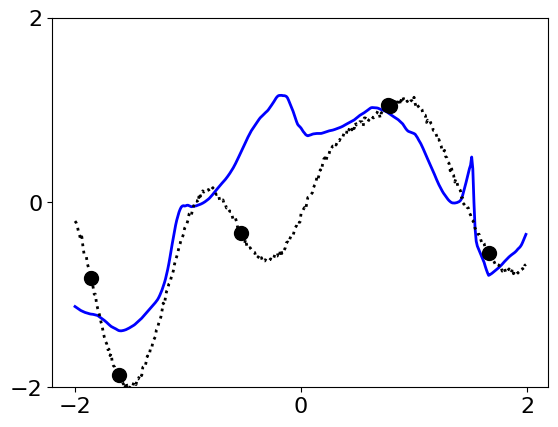

Iteration: 141000, train loss: 0.3627931773662567
Iteration: 142000, train loss: 0.23467615246772766
Iteration: 143000, train loss: 0.3298177421092987
Iteration: 144000, train loss: 0.34487980604171753
Iteration: 145000, train loss: 0.35830020904541016
Iteration: 146000, train loss: 0.4295256733894348
Iteration: 147000, train loss: 0.4508993923664093
Iteration: 148000, train loss: 0.3750999867916107
Iteration: 149000, train loss: 0.40895432233810425
Iteration: 150000, train loss: 0.31516146659851074
Iteration: 151000, train loss: 0.44726958870887756
Iteration: 152000, train loss: 0.32391396164894104
Iteration: 153000, train loss: 0.26565995812416077
Iteration: 154000, train loss: 0.33608198165893555
Iteration: 155000, train loss: 0.2540358006954193
Iteration: 156000, train loss: 0.352156400680542
Iteration: 157000, train loss: 0.30747950077056885
Iteration: 158000, train loss: 0.3147590160369873
Iteration: 159000, train loss: 0.42671236395835876
Iteration: 160000, train loss: 0.3627987

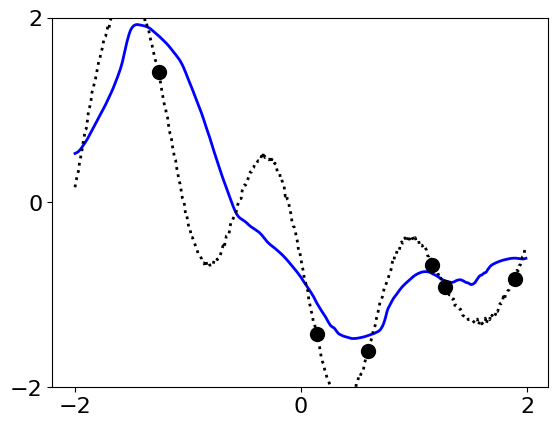

Iteration: 161000, train loss: 0.3168529272079468
Iteration: 162000, train loss: 0.4101317822933197
Iteration: 163000, train loss: 0.28489407896995544
Iteration: 164000, train loss: 0.3419545590877533
Iteration: 165000, train loss: 0.3347003161907196
Iteration: 166000, train loss: 0.3986073136329651
Iteration: 167000, train loss: 0.3926558196544647
Iteration: 168000, train loss: 0.4071800410747528
Iteration: 169000, train loss: 0.3379563093185425
Iteration: 170000, train loss: 0.3144572377204895
Iteration: 171000, train loss: 0.34505724906921387
Iteration: 172000, train loss: 0.3088058531284332
Iteration: 173000, train loss: 0.3196465075016022
Iteration: 174000, train loss: 0.36688554286956787
Iteration: 175000, train loss: 0.25673970580101013
Iteration: 176000, train loss: 0.48464059829711914
Iteration: 177000, train loss: 0.28500720858573914
Iteration: 178000, train loss: 0.37595680356025696
Iteration: 179000, train loss: 0.2613833546638489
Iteration: 180000, train loss: 0.3019032180

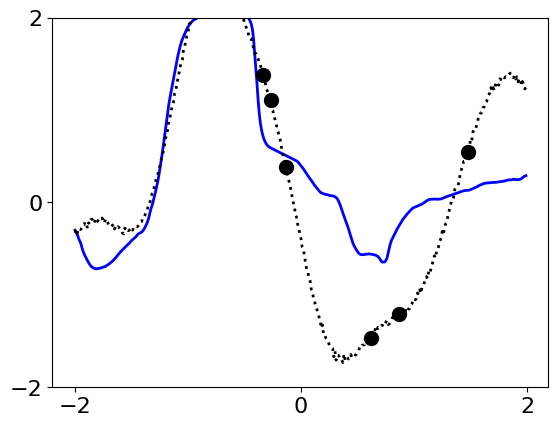

Iteration: 181000, train loss: 0.33982598781585693
Iteration: 182000, train loss: 0.3450089693069458
Iteration: 183000, train loss: 0.30048036575317383
Iteration: 184000, train loss: 0.33659276366233826
Iteration: 185000, train loss: 0.3367445170879364
Iteration: 186000, train loss: 0.29236260056495667
Iteration: 187000, train loss: 0.4321563243865967
Iteration: 188000, train loss: 0.27403971552848816
Iteration: 189000, train loss: 0.3157649636268616
Iteration: 190000, train loss: 0.5365104675292969
Iteration: 191000, train loss: 0.45306769013404846
Iteration: 192000, train loss: 0.37054547667503357
Iteration: 193000, train loss: 0.38266927003860474
Iteration: 194000, train loss: 0.4409669041633606
Iteration: 195000, train loss: 0.36652299761772156
Iteration: 196000, train loss: 0.3377908170223236
Iteration: 197000, train loss: 0.24348889291286469
Iteration: 198000, train loss: 0.3451942205429077
Iteration: 199000, train loss: 0.4640602171421051
Iteration: 200000, train loss: 0.3157163

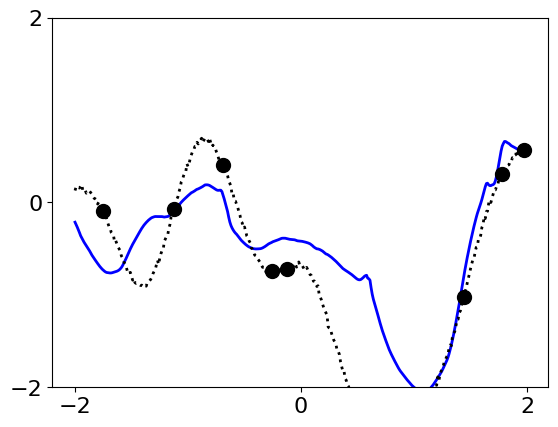

In [3]:
# Model
model = TransformerDecoder(x_dim=1, y_dim=1)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for it in range(TRAINING_ITERATIONS + 1):
    # Sample a batch from the training dataset
    data_train = dataset_train.generate_curves()
    context_x, context_y, target_x, target_y, _, _ = data_train

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)
    optimizer.zero_grad()

    preds = []

    for i in range(target_x.size(1)):
        x_t = target_x[:, i:i+1, :]

        ctx_x = context_x.permute(1, 0, 2)
        ctx_y = context_y.permute(1, 0, 2)

        stacked = torch.stack([ctx_x, ctx_y], dim=1)
        pairs   = stacked.view(-1, context_x.size(0), 1)

        x_t_seq = x_t.permute(1, 0, 2)

        input_seq = torch.cat([pairs, x_t_seq], dim=0)

        out_seq = model(input_seq)
        pred = out_seq[-1]
        preds.append(pred)

    pred_y = torch.cat([p.unsqueeze(1) for p in preds], dim=1)
    loss = criterion(pred_y, target_y)

    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss.item()))

    # Plot and print the loss every PLOT_AFTER iterations
    if it % PLOT_AFTER == 0:
        model.eval()
        with torch.no_grad():
            data_test = dataset_test.generate_curves()
            context_x, context_y, target_x, target_y, _, _ = data_test

            context_x = context_x.to(device)
            context_y = context_y.to(device)
            target_x = target_x.to(device)
            target_y = target_y.to(device)

            preds = []

            for i in range(target_x.size(1)):
                x_t = target_x[:, i:i+1, :]

                ctx_x = context_x.permute(1, 0, 2)
                ctx_y = context_y.permute(1, 0, 2)

                stacked = torch.stack([ctx_x, ctx_y], dim=1)
                pairs   = stacked.view(-1, context_x.size(0), 1)

                x_t_seq = x_t.permute(1, 0, 2)

                input_seq = torch.cat([pairs, x_t_seq], dim=0)

                out_seq = model(input_seq)
                pred = out_seq[-1]
                preds.append(pred)

            pred_y = torch.cat([p.unsqueeze(1) for p in preds], dim=1)
            test_loss = criterion(pred_y, target_y)

            print(
                "{}, Iteration: {}, Test Loss: {}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss.item()
                )
            )
            
            fig_dir = None
            if it in [160000, 180000, 200000]:
                fig_dir = '../images/1d_toy_regression/' + model.__class__.__name__ + '-' + str(it) + '.png'

            plot_functions(
                target_x.detach().cpu().numpy(),
                target_y.detach().cpu().numpy(),
                context_x.detach().cpu().numpy(),
                context_y.detach().cpu().numpy(),
                pred_y.detach().cpu().numpy(),
                save_fig=fig_dir,
            )

In [4]:
torch.save(model.state_dict(), "../models/1d_toy_regression/" + model.__class__.__name__ + ".pt")